In [1]:
%load_ext autoreload
%autoreload 2

In [294]:
import pandas as pd
import networkx as nx
import numpy as np
import os
import json
import sqlite3
import re

In [127]:
from itertools import chain, combinations

# Load Data

In [3]:
parti_df = pd.read_csv("./databases/participants_data.csv")

In [4]:
parti_df.columns

Index(['Name', 'Telephone', 'Zipcode', 'Email', 'ParticipantId',
       'claim_number', 'Role'],
      dtype='object')

In [271]:
cfms_con = sqlite3.connect("./databases/cfms.db")
driver_con = sqlite3.connect("./databases/driver.db")

In [227]:
pd.read_sql("""select * from Participants """, driver_con)

Name   Telephone  Zipcode  \
0            Ibrahim Majid  8106329449    71003   
1                Law Majid  8166502762    20557   
2                Eng Radzi  9470380367    43838   
3       Putrajaya Hospital  9615270959    75832   
4                  Goh Zin  8130516243    75832   
...                    ...         ...      ...   
10680            Liew Chua  9736007298    10053   
10681            Chua Hong  9759742135    40953   
10682          Rahman Chai  8856517984    83715   
10683  Poliklinik Kotaraya  8229268525    33695   
10684             Heng Kok  8687109645    33695   

                                         Email  \
0                ibrahim.majid.4451@@gmail.com   
1                  law.majid.3284@@outlook.com   
2                eng.radzi.2732@@yahoomail.com   
3        putrajayahospital.4752@@yahoomail.com   
4                 goh.zin.1904@@icloudmail.com   
...                                        ...   
10680                 liew.chua.743@@gmail.com   
10681            chua.hong.3550@@yahoomail.com   
10682          rahman.chai.205@@icloudmail.com   
10683  poliklinikkotaraya.3042@@icloudmail.com   
10684               heng.kok.4753@@outlook.com   

                          ParticipantId claim_number      Role  
0      020dccbf24d47d3a89a20d6e7f804b3d     V4297777  Claimant  
1      d0fff6295a792a494baaeb7300879476     V4297777    Doctor  
2      06af4bb5ea397e237db23b72f4843226     V4297777    Lawyer  
3      9c8271562a02b1f4ef359eaabbf91613     V4297777  Hospital  
4      f5df3dc6492730fc0b360e58ebd37f3e     V4297777   Witness  
...                                 ...          ...       ...  
10680  13ffdeef8acb8c7a2e9c39102d1f5972     V4306631  Claimant  
10681  287269d23ff253821f8d1d8c8eebb046     V4306631    Doctor  
10682  49b8aa79359684d35b3ea00f6085e52e     V4306631    Lawyer  
10683  68f932dd4fb699ae3bba71d1e299d8e3     V4306631  Hospital  
10684  56300a3d853696a2a5c136f0fdde6eae     V4306631   Witness  

[10685 rows x 7 columns]

In [226]:
# parti_df.to_sql(name='Participants', con=driver_con, if_exists='replace', index=False)

In [9]:
claimants_df = parti_df[parti_df['Role'] == "Claimant"].copy()

In [11]:
tmp = claimants_df.groupby(['ParticipantId'])['claim_number'].nunique()
tmp[tmp>1].head()

ParticipantId
0311f7b6af09a95afd8a46c28293fd1f    2
031765adff3de14adf04dfb1367c125c    2
03cb28fb765fadffb77e1d2c244f2fc6    2
04ba9113e42cf586cdf8e80fd66c689a    2
06d316b628d393212d6eff66474f6061    3
Name: claim_number, dtype: int64

In [163]:
claimants_df[claimants_df['ParticipantId'] == '06d316b628d393212d6eff66474f6061']

Name   Telephone  Zipcode                          Email  \
7570  Fauzi Hong  9799254202    42139  fauzi.hong.212@@yahoomail.com   
7575  Fauzi Hong  9799254202    42139  fauzi.hong.212@@yahoomail.com   
7580  Fauzi Hong  9799254202    42139  fauzi.hong.212@@yahoomail.com   

                         ParticipantId claim_number      Role  
7570  06d316b628d393212d6eff66474f6061     V4304839  Claimant  
7575  06d316b628d393212d6eff66474f6061     V4302239  Claimant  
7580  06d316b628d393212d6eff66474f6061     V4296635  Claimant

# Create Graph

In [72]:
import networkx as nx

In [58]:
parti_df['Role'].unique()

array(['Claimant', 'Doctor', 'Lawyer', 'Hospital', 'Witness'],
      dtype=object)

In [187]:
# Nodes-Edge List
G = nx.Graph()
node_color_map = {}
for i, row in parti_df.iterrows():
    name = str(row['Name'])
    telephone = str(row['Telephone'])
    zipcode = str(row['Zipcode'])
    email = str(row['Email'])
    parti_id = str(row['ParticipantId'])
    clm_number = str(row['claim_number'])
    role = str(row['Role'])
    
    # Nodes
    G.add_node(clm_number, info_email=email, info_telephone=telephone, label='claim_number')
#     G.add_node(zipcode)
    G.add_node(parti_id, label=role, info_email=email, info_name=name, info_zipcode=zipcode, info_telephone=telephone)
    
    node_color_map[clm_number] = 'red'
    node_color_map[zipcode] = 'gray'
    
    if role == 'Claimant':
        node_color_map[parti_id] = "green"
    elif role == "Lawyer":
        node_color_map[parti_id] = "lime"
    elif role == 'Doctor':
        node_color_map[parti_id] = "blue"
    elif role == "Witness":
        node_color_map[parti_id] = "yellow"
    elif role == 'Hospital':
        node_color_map[parti_id]= "magenta"
    else:
        raise Exception("Unknown Role")
    
    G.add_edge(clm_number, parti_id, label=role)
#     G.add_edge(parti_id, zipcode, label='located at')

In [188]:
# nx.draw(G)

In [161]:
sample_nodes = list(nx.node_connected_component(G, 'V4304839'))
sample_subgraph = G.subgraph(sample_nodes)

node_size_list = []
node_color_list = []
for node in sample_nodes:
    if str(node).startswith("V"):
        node_size_list.append(50)
    else:
        node_size_list.append(20)
    node_color_list.append(node_color_map[node])

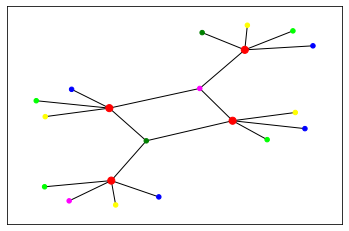

In [162]:
pos = nx.spring_layout(sample_subgraph)
nx.draw_networkx(sample_subgraph, pos=pos, with_labels=False, node_size=node_size_list, node_color=node_color_list)

In [104]:
sample_subgraph.nodes.data()

NodeDataView({'V4302239': {'info_email': 'ramli.kamal.103@@zohomail.com', 'info_telephone': '8256533463', 'label': 'claim_number'}, '9c250dcdbb40351c91835c8a8c15dfd3': {'label': 'Hospital'}, 'a302920e503d387d93f3641ffb83cfd2': {'label': 'Doctor'}, 'fd38f60194468776e44811a651c83edd': {'label': 'Doctor'}, '77c55c7858a5fb12193101df6f39cffd': {'label': 'Lawyer'}, 'V4304839': {'info_email': 'ku.sim.4764@@yahoomail.com', 'info_telephone': '8149439675', 'label': 'claim_number'}, 'da86d620ba7ec3e0378984af83bfb10e': {'label': 'Witness'}, '4e9ae53059cd70692e8e85d1a17abef0': {'label': 'Hospital'}, 'b45b28bea954c9d5f901f6da3a165c1b': {'label': 'Witness'}, 'dbcbd2b4b21aef48e83cc649da327853': {'label': 'Witness'}, 'c88622260fbd3981dd3ac90258a875c0': {'label': 'Witness'}, 'bed23720b7155c5e26cd7a9247b4949a': {'label': 'Doctor'}, '21de472bca804b0915b8a94a8b200d98': {'label': 'Lawyer'}, 'V4296635': {'info_email': 'nor.rahman.2100@@yahoomail.com', 'info_telephone': '8658119292', 'label': 'claim_number'},

In [170]:
l1 = list(G.neighbors("V4304839"))

In [171]:
l2 = list(G.neighbors("V4296635"))

In [172]:
l3 = list(G.neighbors("V4302239"))

In [173]:
set(l1).intersection(set(l2)).intersection(set(l3))

{'06d316b628d393212d6eff66474f6061'}

In [177]:
l1, l2, l3

(['06d316b628d393212d6eff66474f6061',
  'bed23720b7155c5e26cd7a9247b4949a',
  '21de472bca804b0915b8a94a8b200d98',
  '9c250dcdbb40351c91835c8a8c15dfd3',
  'b45b28bea954c9d5f901f6da3a165c1b'],
 ['06d316b628d393212d6eff66474f6061',
  'fd38f60194468776e44811a651c83edd',
  '22c383cfbba21a8a9b89d72218635bbe',
  '4e9ae53059cd70692e8e85d1a17abef0',
  'dbcbd2b4b21aef48e83cc649da327853'],
 ['06d316b628d393212d6eff66474f6061',
  'b6ade9841df601711c0e9099c2273241',
  '77c55c7858a5fb12193101df6f39cffd',
  '9c250dcdbb40351c91835c8a8c15dfd3',
  'da86d620ba7ec3e0378984af83bfb10e'])

In [176]:
list(G.neighbors("V4302030"))

['34b8287f608326e6595673c4c5c824c4',
 'a302920e503d387d93f3641ffb83cfd2',
 '631f64f3df6b88b2e9346b5d19f4932e',
 '9c250dcdbb40351c91835c8a8c15dfd3',
 'c88622260fbd3981dd3ac90258a875c0']

In [174]:
nx.node_connected_component(G, "V4302239")

{'06d316b628d393212d6eff66474f6061',
 '21de472bca804b0915b8a94a8b200d98',
 '22c383cfbba21a8a9b89d72218635bbe',
 '34b8287f608326e6595673c4c5c824c4',
 '4e9ae53059cd70692e8e85d1a17abef0',
 '631f64f3df6b88b2e9346b5d19f4932e',
 '77c55c7858a5fb12193101df6f39cffd',
 '9c250dcdbb40351c91835c8a8c15dfd3',
 'V4296635',
 'V4302030',
 'V4302239',
 'V4304839',
 'a302920e503d387d93f3641ffb83cfd2',
 'b45b28bea954c9d5f901f6da3a165c1b',
 'b6ade9841df601711c0e9099c2273241',
 'bed23720b7155c5e26cd7a9247b4949a',
 'c88622260fbd3981dd3ac90258a875c0',
 'da86d620ba7ec3e0378984af83bfb10e',
 'dbcbd2b4b21aef48e83cc649da327853',
 'fd38f60194468776e44811a651c83edd'}

In [233]:
nx.write_gpickle(G, "/home/bridgei2i/CFMS/cfms_dev/cfms/backend/flask_app/databases/graph_network.gpickle")

In [234]:
G = nx.read_gpickle("/home/bridgei2i/CFMS/cfms_dev/cfms/backend/flask_app/databases/graph_network.gpickle")

# Create subgraph json

In [286]:
class Subgraph:
    
    def __init__(self, G, n):
        self.root_node = n
        self.all_connected_nodes = list(nx.node_connected_component(G, n))
        self.G = G
        self.subgraph = G.subgraph(self.all_connected_nodes)
        self.subgraph_nodes_data = dict(eval(self.subgraph.nodes.data().__str__()))
        self._connected_claim_nodes = self.compute_connected_claim_nodes()
               
    def compute_connected_claim_nodes(self,):
        connected_claim_nodes = []
        for k, v in self.subgraph_nodes_data.items():
            if v['label'] == 'claim_number':
                connected_claim_nodes.append(k)
        return connected_claim_nodes
    
    def _neighbours(self, n):
        return list(self.G.neighbors(n))
    
    def _label(self, n):
        return self.subgraph_nodes_data[n]['label']
    
    def _info_dict(self, n):
        return self.subgraph_nodes_data[n]
    
    def _node_base_dict(self, n, value=10):
        if self._label(n) != "claim_number":
            return {"id": n, "name": self._label(n), "value": "1", "info_name": self._info_dict(n)['info_name'] }
        else:
            return {"id": n, "name": self._label(n), "value": "10"}
    
    def create_graph_json(self, ):
        graph_json = {}
        
        nodes_to_traverse = [self.root_node] + list(set(self._connected_claim_nodes).difference([self.root_node]))
        
        for i, node in enumerate(nodes_to_traverse):
            node_label = self.subgraph_nodes_data[node]['label']
            graph_json[f"{node}"] = {"id": f"{node}", "name": node_label, "value": "10"}
        
        for node1, node2 in combinations(nodes_to_traverse, 2):
            node1_neighbours = self._neighbours(node1)
            node2_neighbours = self._neighbours(node2)
            common = list(set(node1_neighbours).intersection(set(node2_neighbours)))  
            node1_children = [self._node_base_dict(n, value=1) for n in list(set(node1_neighbours).difference(common))]
            node2_children = [self._node_base_dict(n, value=1) for n in list(set(node2_neighbours).difference(common))]
            for neighbour in node1_children:
                if "children" not in graph_json[f"{node1}"]:
                    graph_json[f"{node1}"]["children"] = []
                if neighbour not in graph_json[f"{node1}"]['children']:
                    graph_json[f"{node1}"]['children'].append(neighbour)
                    
            if len(common) !=0 :
                if "link" not in graph_json[f"{node2}"]:
                    graph_json[f"{node2}"]['link'] = []
                    
                for c in common:
                    if c not in graph_json[f"{node2}"]['link']:
                        graph_json[f"{node2}"]['link'].extend(common)
                        
            for neighbour in node2_children:
                if "children" not in graph_json[f"{node2}"]:
                    graph_json[f"{node2}"]["children"] = []
                if (neighbour not in graph_json[f"{node2}"]['children']) and (neighbour['id'] not in graph_json[f"{node2}"]['link']):
                    graph_json[f"{node2}"]['children'].append(neighbour)
                    
        # Prune the json
        for i, node in enumerate(nodes_to_traverse):
            if 'children' in graph_json[f"{node}"]:
                all_childs = [c['id'] for c in graph_json[f"{node}"]['children']]
            else:
                all_childs = []
            
            if 'link' in  graph_json[f"{node}"]:
                new_link = list(set(graph_json[f"{node}"]['link']).difference(set(all_childs)))
                if len(new_link) != 0:
                    graph_json[f"{node}"]['link'] = new_link
                else:
                    graph_json[f"{node}"].pop('link')
                    
            
        return graph_json
            

root_node = 'V4302239'

obj = Subgraph(G, n=root_node)
graph_json = obj.create_graph_json()

In [287]:
obj.subgraph_nodes_data['V4302239']

{'info_email': 'ramli.kamal.103@@zohomail.com',
 'info_telephone': '8256533463',
 'label': 'claim_number'}

In [288]:
json.dumps(list(graph_json.values()))

'[{"id": "V4302239", "name": "claim_number", "value": "10", "children": [{"id": "06d316b628d393212d6eff66474f6061", "name": "Claimant", "value": "1", "info_name": "Fauzi Hong"}, {"id": "da86d620ba7ec3e0378984af83bfb10e", "name": "Witness", "value": "1", "info_name": "Ramli Kamal"}, {"id": "77c55c7858a5fb12193101df6f39cffd", "name": "Lawyer", "value": "1", "info_name": "Pang Radzi"}, {"id": "b6ade9841df601711c0e9099c2273241", "name": "Doctor", "value": "1", "info_name": "Othman Rashid"}, {"id": "9c250dcdbb40351c91835c8a8c15dfd3", "name": "Hospital", "value": "1", "info_name": "Hospital Pasir Gudang\\u00a0(under construction)"}]}, {"id": "V4302030", "name": "claim_number", "value": "10", "children": [{"id": "34b8287f608326e6595673c4c5c824c4", "name": "Claimant", "value": "1", "info_name": "Aziz Rahman"}, {"id": "a302920e503d387d93f3641ffb83cfd2", "name": "Doctor", "value": "1", "info_name": "Nor Chow"}, {"id": "c88622260fbd3981dd3ac90258a875c0", "name": "Witness", "value": "1", "info_nam

In [205]:
json.dumps(list(graph_json.values()))

'[{"id": "V4302239", "name": "claim_number", "value": "10", "children": [{"id": "06d316b628d393212d6eff66474f6061", "name": "Claimant", "value": "1"}, {"id": "da86d620ba7ec3e0378984af83bfb10e", "name": "Witness", "value": "1"}, {"id": "77c55c7858a5fb12193101df6f39cffd", "name": "Lawyer", "value": "1"}, {"id": "b6ade9841df601711c0e9099c2273241", "name": "Doctor", "value": "1"}, {"id": "9c250dcdbb40351c91835c8a8c15dfd3", "name": "Hospital", "value": "1"}]}, {"id": "V4302030", "name": "claim_number", "value": "10", "link": ["9c250dcdbb40351c91835c8a8c15dfd3"], "children": [{"id": "9c250dcdbb40351c91835c8a8c15dfd3", "name": "Hospital", "value": "1"}, {"id": "34b8287f608326e6595673c4c5c824c4", "name": "Claimant", "value": "1"}, {"id": "a302920e503d387d93f3641ffb83cfd2", "name": "Doctor", "value": "1"}, {"id": "c88622260fbd3981dd3ac90258a875c0", "name": "Witness", "value": "1"}, {"id": "631f64f3df6b88b2e9346b5d19f4932e", "name": "Lawyer", "value": "1"}]}, {"id": "V4296635", "name": "claim_nu

In [301]:
class Subgraph():
    
    def __init__(self, G=None):
        super().__init__()
        if G is None:
            load_stat = self.load_graph()
            if not load_stat:
                print("Error loading the Graph")
        else:
            self.G = G
        self.all_connected_nodes = None
        self.subgraph = None
        self.subgraph_nodes_data = None
        self._connected_claim_nodes = None
        self.node_list = []
        
    def compute_subgraph(self, n):
        # Connected components based on given node n
        self.all_connected_nodes = list(nx.node_connected_component(self.G, n))
        self.subgraph = self.G.subgraph(self.all_connected_nodes)
        self.subgraph_nodes_data = dict(eval(self.subgraph.nodes.data().__str__()))
#         self._connected_claim_nodes = self.compute_connected_claim_nodes()
        
    def _connected_claims(self, n):
        connected_claim_nodes = []
        for node in self._neighbours(n):
            if self._label(node) == 'claim_number':
                connected_claim_nodes.append(node)
        return connected_claim_nodes
    
    def _neighbours(self, n):
        return list(self.G.neighbors(n))
    
    def _label(self, n):
        return self.subgraph_nodes_data[n]['label']
    
    def _info_dict(self, n):
        return self.subgraph_nodes_data[n]
    
    def _node_base_dict(self, n, value=10):
        if self._label(n) != "claim_number":
            info_name = self._info_dict(n)['info_name']
            info_name = re.sub(r'[^a-zA-Z]', ' ', info_name).title().replace("Under Construction", "").strip()
            return {"id": n, "name": self._label(n), "value": "1", "info_name": info_name }
        else:
            return {"id": n, "name": self._label(n), "value": "10"}
        
    def create_graph_json(self, n):
        
        self.compute_subgraph(n)
        
        graph_json = {}
        for k, v in self.subgraph_nodes_data.items():
            graph_json[k] = self._node_base_dict(n=k)
            if self._label(k) != "claim_number":
                links = list(set(self._connected_claims(n=k)))
                if len(links) != 0:
                    graph_json[k]['link'] = links
            
        return graph_json
    
    def create_graph_json_v2(self, n):
        
        self.compute_subgraph(n)
        
        graph_json = {}
        root_node = self._node_base_dict(n)
        graph_json.update(root_node)
        for node in self._neighbours(self.G, n):
            if 'children' not in graph_json:
                graph_json['children'] = []
            graph_json['children'].append(self._node_base_dict(node))
        
   
        return graph_json
            

root_node = 'V4302239'

obj = Subgraph(G)
graph_json = obj.create_graph_json(n=root_node)

In [302]:
json.dumps(list(graph_json.values()))

'[{"id": "V4302239", "name": "claim_number", "value": "10"}, {"id": "9c250dcdbb40351c91835c8a8c15dfd3", "name": "Hospital", "value": "1", "info_name": "Hospital Pasir Gudang", "link": ["V4302239", "V4302030", "V4304839"]}, {"id": "a302920e503d387d93f3641ffb83cfd2", "name": "Doctor", "value": "1", "info_name": "Nor Chow", "link": ["V4302030"]}, {"id": "fd38f60194468776e44811a651c83edd", "name": "Doctor", "value": "1", "info_name": "Shah Goh", "link": ["V4296635"]}, {"id": "77c55c7858a5fb12193101df6f39cffd", "name": "Lawyer", "value": "1", "info_name": "Pang Radzi", "link": ["V4302239"]}, {"id": "V4304839", "name": "claim_number", "value": "10"}, {"id": "da86d620ba7ec3e0378984af83bfb10e", "name": "Witness", "value": "1", "info_name": "Ramli Kamal", "link": ["V4302239"]}, {"id": "4e9ae53059cd70692e8e85d1a17abef0", "name": "Hospital", "value": "1", "info_name": "Hospital Lundu", "link": ["V4296635"]}, {"id": "dbcbd2b4b21aef48e83cc649da327853", "name": "Witness", "value": "1", "info_name": 

In [324]:
list(nx.dfs_preorder_nodes(obj.subgraph, source='V4302239'))

['V4302239',
 '06d316b628d393212d6eff66474f6061',
 'V4304839',
 'bed23720b7155c5e26cd7a9247b4949a',
 '21de472bca804b0915b8a94a8b200d98',
 '9c250dcdbb40351c91835c8a8c15dfd3',
 'V4302030',
 '34b8287f608326e6595673c4c5c824c4',
 'a302920e503d387d93f3641ffb83cfd2',
 '631f64f3df6b88b2e9346b5d19f4932e',
 'c88622260fbd3981dd3ac90258a875c0',
 'b45b28bea954c9d5f901f6da3a165c1b',
 'V4296635',
 'fd38f60194468776e44811a651c83edd',
 '22c383cfbba21a8a9b89d72218635bbe',
 '4e9ae53059cd70692e8e85d1a17abef0',
 'dbcbd2b4b21aef48e83cc649da327853',
 'b6ade9841df601711c0e9099c2273241',
 '77c55c7858a5fb12193101df6f39cffd',
 'da86d620ba7ec3e0378984af83bfb10e']

In [308]:
node_link_data = nx.node_link_data(obj.subgraph)

In [318]:
node_link_df = pd.DataFrame(node_link_data['links'])
node_link_df['source-target'] = node_link_df.apply(lambda x: "-".join(sorted([x['source'], x['target']])), axis=1 )
node_link_df2 = node_link_df.drop_duplicates(subset=['source-target'])

In [322]:
node_link_df2.head()

label    source                            target  \
0  Claimant  V4302239  06d316b628d393212d6eff66474f6061   
1    Doctor  V4302239  b6ade9841df601711c0e9099c2273241   
2    Lawyer  V4302239  77c55c7858a5fb12193101df6f39cffd   
3  Hospital  V4302239  9c250dcdbb40351c91835c8a8c15dfd3   
4   Witness  V4302239  da86d620ba7ec3e0378984af83bfb10e   

                               source-target  
0  06d316b628d393212d6eff66474f6061-V4302239  
1  V4302239-b6ade9841df601711c0e9099c2273241  
2  77c55c7858a5fb12193101df6f39cffd-V4302239  
3  9c250dcdbb40351c91835c8a8c15dfd3-V4302239  
4  V4302239-da86d620ba7ec3e0378984af83bfb10e

In [325]:
class Node:
    def __init__(self, node_id, name, value, link=[], children=[]):
        self.node_id = node_id
        self.name = name
        self.value = value
        self.link = link
        self.children = children
        
    def update_links(self, link_list):
        new_link_list = list(set(link_list).union(set(self.link)))
        self.link.extend(new_link_list)
        
    def update_children(self, child_list):
        for ch in child_list:
            self.children.append(children)
        

class GraphJson(Subgraph):
    
    def __init__(self):
        super().__init__()
        self.graph_json = {}
        self.visited = []
        
    def _init_child(self, n):
        if 'children' not in n:
            self.graph_json[n]['children'] = []
    
    def _init_link(self, n):
        if 'link' not in n:
            self.graph_json[n]['link'] = []
    
    def _init_root(self, n):
        self.graph_json[n] = self._node_base_dict(n)
        
    def isleaf(self, n):
        if self.G.degree(n) == 1:
            return True
        else:
            return False        
            
    def get_child(self, n):
        for node in self._neighbours(n):
            if node not in self.visited:
                self.visited.append(node)
                if self.isleaf(node):
                    self._init_child(self.graph_json[node])
                    return self._node_base_dict(node)
                else:
                    self.get_child(node)
            
    
    def get_non_leaf_node(self, n):
        self._init_base_dict(n)
        
        
    def run(self, n):
        self.compute_subgraph(n)

In [509]:
class Node:
    def __init__(self, node_id, name, value, link=None, children=None):
        self.node_id = node_id
        self.name = name
        self.value = value
        if link is None:
            self.link = []
        else:
            self.link = link
        if children is None:
            self.children = []
        else:
            self.children = children
        
        self.visited = []

        
class CreateNode:
    def __init__(self, G):
        self.visited = []
        self.G = G
        
    def compute_subgraph(self, n):
        # Connected components based on given node n
        self.all_connected_nodes = list(nx.node_connected_component(self.G, n))
        self.subgraph = self.G.subgraph(self.all_connected_nodes)
        self.subgraph_nodes_data = dict(eval(self.subgraph.nodes.data().__str__()))
        
    def _name(self, n):
        return self.subgraph_nodes_data[n]['label']
    
    def _id(self, n):
        return n
    
    def _value(self, n):
        if self._name(n) != 'claim_number':
            return "1"
        else:
            return "10"
    
    def isleaf(self, n):
        if G.degree(n) == 1:
            return True
        else:
            return False
                    
    def run(self, node_obj):
        neighbors_list = self.G.neighbors(node_obj.node_id)
        self.visited.append(node_obj.node_id)
        for neighbor in neighbors_list:
            if neighbor not in self.visited:
                self.visited.append(neighbor)
                neighbor_node_obj = Node(node_id=self._id(neighbor), 
                                         name=self._name(neighbor), 
                                         value=self._value(neighbor))
                if self.isleaf(neighbor):
                    node_obj.children.extend([neighbor_node_obj])
                else:
                    node_obj.children.extend([neighbor_node_obj])
                    self.run(neighbor_node_obj)
            else:
                node_obj.link.extend([neighbor])
                
                
    
def node_json(node):
    if len(node.children) == 0:
        req_json = {"id": node.node_id, "name": node.name, "value": node.value, "link": node.link, "collapsed": "true"}
        if len(node.link) == 0:
            req_json.pop("link")
        return req_json
    else:
        req_json = {"id": node.node_id, "name": node.name, "value": node.value, "link": node.link, "collapsed": "true",
                    "children": [node_json(c) for c in node.children] }
        if len(node.link) == 0:
            req_json.pop("link")
        return req_json

In [510]:
creat_node_obj = CreateNode(G=obj.subgraph)

creat_node_obj.compute_subgraph(n="V4302239")

In [511]:
root_node = Node(node_id="V4302239", 
                 name="claim_number",
                 value="10",
                 children=None)
creat_node_obj.run(node_obj=root_node)

In [512]:
json.dumps(node_json(root_node))

'{"id": "V4302239", "name": "claim_number", "value": "10", "link": ["9c250dcdbb40351c91835c8a8c15dfd3"], "collapsed": "true", "children": [{"id": "06d316b628d393212d6eff66474f6061", "name": "Claimant", "value": "1", "link": ["V4302239"], "collapsed": "true", "children": [{"id": "V4304839", "name": "claim_number", "value": "10", "link": ["06d316b628d393212d6eff66474f6061"], "collapsed": "true", "children": [{"id": "bed23720b7155c5e26cd7a9247b4949a", "name": "Doctor", "value": "1", "collapsed": "true"}, {"id": "21de472bca804b0915b8a94a8b200d98", "name": "Lawyer", "value": "1", "collapsed": "true"}, {"id": "9c250dcdbb40351c91835c8a8c15dfd3", "name": "Hospital", "value": "1", "link": ["V4304839", "V4302239"], "collapsed": "true", "children": [{"id": "V4302030", "name": "claim_number", "value": "10", "link": ["9c250dcdbb40351c91835c8a8c15dfd3"], "collapsed": "true", "children": [{"id": "34b8287f608326e6595673c4c5c824c4", "name": "Claimant", "value": "1", "collapsed": "true"}, {"id": "a30292

In [406]:
a = Node(node_id='V1234', name='A', value='A')
ac = Node(node_id='C1234', name='a1', value='a1')
bc = Node(node_id='BC1234', name='b1', value='b1')
acc = Node(node_id='C2234', name='a2', value='a2')

a.children, ac.children, acc.children

([], [], [])

In [407]:
a.children.append(ac)

In [408]:
ac.children.append(acc)

In [409]:
a.children.append(bc)

In [411]:
json.dumps(node_json(a))

node:  V1234
children:  [<__main__.Node object at 0x7fc620d5a730>, <__main__.Node object at 0x7fc62142fe50>]
node:  C1234
children:  [<__main__.Node object at 0x7fc62142fee0>]
node:  C2234
children:  []
node:  BC1234
children:  []


'{"id": "V1234", "name": "A", "value": "A", "link": [], "children": [{"id": "C1234", "name": "a1", "value": "a1", "link": [], "children": [{"id": "C2234", "name": "a2", "value": "a2", "link": []}]}, {"id": "BC1234", "name": "b1", "value": "b1", "link": []}]}'